In [1]:
import pandas as pd
import numpy as np
import re
import inflect
from word2number import w2n

import matplotlib.pyplot as plt
import seaborn as sb
from prettytable import PrettyTable

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
malayalam_data = pd.read_csv("mal_train.csv")
malayalam_val = pd.read_csv("mal_val.csv").replace(".", "asterisk").replace("•","asterisks").fillna("")

kanada_data = pd.read_csv("kn_train.csv")
kanada_val = pd.read_csv("kn_val.csv")
kanada_data = pd.concat([kanada_data, kanada_val], axis=0)

tamil_data = pd.read_csv("tamil_train.csv")
tamil_val = pd.read_csv("tamil_val.csv")
tamil_data = pd.concat([tamil_data, tamil_val], axis=0)

tulu_data = pd.read_csv("tulu_train.csv")
tulu_val = pd.read_csv("tulu_val.csv")
tulu_data = pd.concat([tulu_data, tulu_val], axis=0)

# Removing unnecessary data and converting Symbols to Words for Better Vectorization
malayalam_data = malayalam_data[~(~(malayalam_data["Word"].isin([".", "•"])) & (malayalam_data["Tag"] == "SYM"))].replace(".", "asterisk").replace("•", "asterisks").fillna("")

# Oversampling "mixed", "other", "number" and "en" categories to improve their accuracy
malayalam_mixed = malayalam_data[malayalam_data["Tag"] == "MIXED"]
malayalam_other = malayalam_data[malayalam_data["Tag"] == "OTHER"]
malayalam_number = malayalam_data[malayalam_data["Tag"] == "NUMBER"]
malayalam_eng = malayalam_data[malayalam_data["Tag"] == "ENGLISH"]

# Names from other languages are also included (More the data, Better the performance)
tamil_name = tamil_data[tamil_data["Tag"] == "name"]
tamil_name["Tag"] = tamil_name["Tag"].replace("name", "NAME")
kanada_name = kanada_data[kanada_data["Tag"] == "name"]
kanada_name["Tag"] = kanada_name["Tag"].replace("name", "NAME")
tulu_name = tulu_data[tulu_data["Language"] == "Name"]
tulu_name.columns = ["Word", "Tag"]
tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "NAME")
malayalam_name = malayalam_data[malayalam_data["Tag"] == "NAME"]

# Locations from other languages are also included
tamil_loc = tamil_data[tamil_data["Tag"] == "Location"]
tamil_loc["Tag"] = tamil_loc["Tag"].replace("Location", "PLACE")
kanada_loc = kanada_data[kanada_data["Tag"] == "location"]
kanada_loc["Tag"] = kanada_loc["Tag"].replace("location", "PLACE")
tulu_loc = tulu_data[tulu_data["Language"] == "Location"]
tulu_loc.columns = ["Word", "Tag"]
tulu_loc["Tag"] = tulu_loc["Tag"].replace("Location", "PLACE")
malayalam_loc = malayalam_data[malayalam_data["Tag"] == "PLACE"]

# Code to convert Number to Words for Vectorization of the Texts
p = inflect.engine()

def number_to_words(text):
    # Regular expression to find all numbers in the text
    pattern = re.compile(r'(\d+)')
    
    def replace_func(match):
        number = match.group(1)
        number_in_words = p.number_to_words(number)
        return f"_{number_in_words.replace(' ', '_')}_"
    
    return pattern.sub(replace_func, text)


# Combining all the data needed for training
malayalam_data = pd.concat([malayalam_data, malayalam_mixed, kanada_loc, malayalam_eng, malayalam_other, kanada_name, tulu_name, malayalam_number, malayalam_mixed,tamil_name, malayalam_mixed, tulu_loc, malayalam_other, tamil_loc, malayalam_loc, malayalam_mixed, malayalam_name]).fillna("")
malayalam_data["Word"] = malayalam_data["Word"].apply(number_to_words)
malayalam_val["Word"] = malayalam_val["Word"].apply(number_to_words)

malayalam_data_with_val = pd.concat([malayalam_data, malayalam_val])

C:\Users\justa\AppData\Local\Temp\ipykernel_15412\1792644365.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tamil_name["Tag"] = tamil_name["Tag"].replace("name", "NAME")
C:\Users\justa\AppData\Local\Temp\ipykernel_15412\1792644365.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kanada_name["Tag"] = kanada_name["Tag"].replace("name", "NAME")
C:\Users\justa\AppData\Local\Temp\ipykernel_15412\1792644365.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [3]:
malayalam_data["Tag"].value_counts()

Tag
MALAYALAM    11233
ENGLISH      10984
NAME          8208
OTHER         6324
MIXED         3810
SYM           2771
NUMBER        1136
PLACE          933
Name: count, dtype: int64

In [4]:
malayalam_data_with_val["Tag"].value_counts()

Tag
MALAYALAM    12408
ENGLISH      11522
NAME          8377
OTHER         6503
MIXED         3873
SYM           3065
NUMBER        1213
PLACE          942
Name: count, dtype: int64

<Axes: xlabel='Tag', ylabel='Count'>

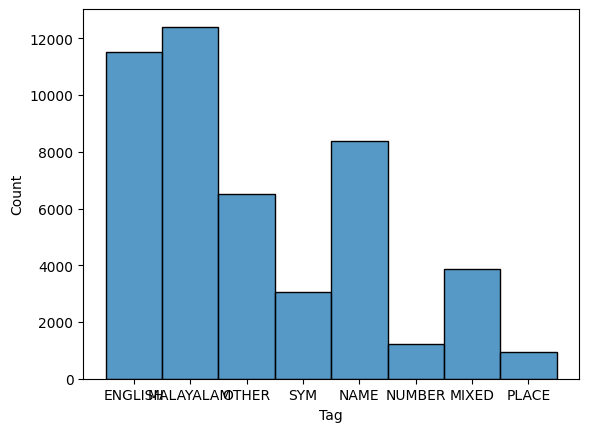

In [5]:
sb.histplot(malayalam_data_with_val["Tag"])

In [6]:
malayalam_data.describe()

,Word,Tag
count,45399,45399
unique,11743,8
top,asterisk,MALAYALAM
freq,2787,11233


In [7]:
malayalam_val.describe()

,Word,Tag
count,2504,2504
unique,1468,8
top,asterisk,MALAYALAM
freq,292,1175


In [8]:
countVectorizer = CountVectorizer(ngram_range=(1,5), analyzer='char')
tfidf = TfidfVectorizer(ngram_range=(1,5),analyzer='char')
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model1 = MultinomialNB()
model2 = MultinomialNB()

model3 = LogisticRegression(solver='newton-cg', max_iter=2000)
model4 = LogisticRegression(solver='newton-cg', max_iter=2000)

model5 = svm.SVC()
model6 = svm.SVC()

model8 = DecisionTreeClassifier(random_state=42)
model9 = DecisionTreeClassifier(random_state=42)

model7 = VotingClassifier(
    estimators=[
        ('dtc', model8),
        ('lr', model3),
        ('svm', model5),
    ],
    voting='hard'
)



acc = [[], [], [], [], [], [], [], []] 
f1 = [[], [], [], [], [], [], [], []]
pre = [[], [], [], [], [], [], [], []]
rec = [[], [], [], [], [], [], [], []]

f1_a = [[], [], [], [], [], [], [], []]

In [8]:
X = malayalam_data_with_val["Word"]
Y = malayalam_data_with_val["Tag"]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    

    train_vect_count = countVectorizer.fit_transform(X_train)
    test_vect_count = countVectorizer.transform(X_test)

    train_vect_tf = tfidf.fit_transform(X_train)
    test_vect_tf = tfidf.transform(X_test)


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
    model1.fit(train_vect_count, y_train)
    model1_predict = model1.predict(test_vect_count)

    acc[0].append(accuracy_score(y_test, model1_predict))
    f1[0].append(f1_score(y_test, model1_predict, average='macro'))
    f1_a[0].append(f1_score(y_test, model1_predict, average='weighted'))
    pre[0].append(precision_score(y_test, model1_predict, average='macro', zero_division=np.nan))
    rec[0].append(recall_score(y_test, model1_predict, average='macro', zero_division=np.nan))


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
    model2.fit(train_vect_tf, y_train)
    model2_predict = model2.predict(test_vect_tf)

    acc[1].append(accuracy_score(y_test, model2_predict))
    f1[1].append(f1_score(y_test, model2_predict, average='macro'))
    f1_a[1].append(f1_score(y_test, model2_predict, average='weighted'))
    pre[1].append(precision_score(y_test, model2_predict, average="macro", zero_division=np.nan))
    rec[1].append(recall_score(y_test, model2_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using COUNT VECTORIZATION
    model3.fit(train_vect_count, y_train)
    model3_predict = model3.predict(test_vect_count)

    acc[2].append(accuracy_score(y_test, model3_predict))
    f1[2].append(f1_score(y_test, model3_predict, average="macro"))
    f1_a[2].append(f1_score(y_test, model3_predict, average="weighted"))
    pre[2].append(precision_score(y_test, model3_predict, average="macro", zero_division=np.nan))
    rec[2].append(recall_score(y_test, model3_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using TFIDF VECTORIZATION
    model4.fit(train_vect_tf, y_train)
    model4_predict = model4.predict(test_vect_tf)

    acc[3].append(accuracy_score(y_test, model4_predict))
    f1[3].append(f1_score(y_test, model4_predict, average="macro"))
    f1_a[3].append(f1_score(y_test, model4_predict, average="weighted"))
    pre[3].append(precision_score(y_test, model4_predict, average="macro", zero_division=np.nan))
    rec[3].append(recall_score(y_test, model4_predict, average="macro", zero_division=np.nan))

    # SVM using COUNT VECTORIZATION
    model5.fit(train_vect_count, y_train)
    model5_predict = model5.predict(test_vect_count)

    acc[4].append(accuracy_score(y_test, model5_predict))
    f1[4].append(f1_score(y_test, model5_predict, average="macro"))
    f1_a[4].append(f1_score(y_test, model5_predict, average="weighted"))
    pre[4].append(precision_score(y_test, model5_predict, average="macro", zero_division=np.nan))
    rec[4].append(recall_score(y_test, model5_predict, average="macro", zero_division=np.nan))

    # SVM using TFIDF VECTORIZATION
    model6.fit(train_vect_tf, y_train)
    model6_predict = model6.predict(test_vect_tf)

    acc[5].append(accuracy_score(y_test, model6_predict))
    f1[5].append(f1_score(y_test, model6_predict, average="macro"))
    f1_a[5].append(f1_score(y_test, model6_predict, average="weighted"))
    pre[5].append(precision_score(y_test, model6_predict, average="macro", zero_division=np.nan))
    rec[5].append(recall_score(y_test, model6_predict, average="macro", zero_division=np.nan))

    # Decision Tree Classifier using COUNT VECTORIZATION
    model8.fit(train_vect_count, y_train)
    model8_predict = model8.predict(test_vect_count)

    acc[6].append(accuracy_score(y_test, model8_predict))
    f1[6].append(f1_score(y_test, model8_predict, average="macro"))
    f1_a[6].append(f1_score(y_test, model8_predict, average="weighted"))
    pre[6].append(precision_score(y_test, model8_predict, average="macro", zero_division=np.nan))
    rec[6].append(recall_score(y_test, model8_predict, average="macro", zero_division=np.nan))

    # Decision Tree Classifier using TFIDF VECTORIZATION
    model9.fit(train_vect_tf, y_train)
    model9_predict = model9.predict(test_vect_tf)

    acc[7].append(accuracy_score(y_test, model9_predict))
    f1[7].append(f1_score(y_test, model9_predict, average="macro"))
    f1_a[7].append(f1_score(y_test, model9_predict, average="weighted"))
    pre[7].append(precision_score(y_test, model9_predict, average="macro", zero_division=np.nan))
    rec[7].append(recall_score(y_test, model9_predict, average="macro", zero_division=np.nan))

In [9]:
MNB_count = ["MultinomialNB (Count)",sum(acc[0])/len(acc[0]), sum(f1[0])/len(f1[0]), sum(f1_a[0])/len(f1_a[0]),sum(pre[0])/len(pre[0]), sum(rec[0])/len(rec[0])]
MNB_tf = ["MultinomialNB (TFIDF)", sum(acc[1])/len(acc[1]), sum(f1[1])/len(f1[1]), sum(f1_a[1])/len(f1_a[1]), sum(pre[1])/len(pre[1]), sum(rec[1])/len(rec[1])]
Logistic_count = ["Logistic (Count)",sum(acc[2])/len(acc[2]), sum(f1[2])/len(f1[2]), sum(f1_a[2])/len(f1_a[2]), sum(pre[2])/len(pre[2]), sum(rec[2])/len(rec[2])]
Logistic_tf = ["Logistic (TFIDF)", sum(acc[3])/len(acc[3]), sum(f1[3])/len(f1[3]), sum(f1_a[3])/len(f1_a[3]), sum(pre[3])/len(pre[3]), sum(rec[3])/len(rec[3])]
SVM_count = ["SVM (Count)", sum(acc[4])/len(acc[4]), sum(f1[4])/len(f1[4]), sum(f1_a[4])/len(f1_a[4]), sum(pre[4])/len(pre[4]), sum(rec[4])/len(rec[4])]
SVM_tf = ["SVM (TFIDF)", sum(acc[5])/len(acc[5]), sum(f1[5])/len(f1[5]), sum(f1_a[5])/len(f1_a[5]), sum(pre[5])/len(pre[5]), sum(rec[5])/len(rec[5])]
DTC_count = ["DTC (Count)", sum(acc[6])/len(acc[6]), sum(f1[6])/len(f1[6]), sum(f1_a[6])/len(f1_a[6]), sum(pre[6])/len(pre[6]), sum(rec[6])/len(rec[6])]
DTC_tf = ["DTC (Count)", sum(acc[7])/len(acc[7]), sum(f1[7])/len(f1[7]), sum(f1_a[7])/len(f1_a[7]), sum(pre[7])/len(pre[7]), sum(rec[7])/len(rec[7])]

fields = ["Model Name", "Accuracy", "F1 Score (Macro)", "F1 Score (Weighted)", "Precision", "Recall Score"]

table = PrettyTable(field_names=fields)
table.add_rows([MNB_count, MNB_tf, Logistic_count, Logistic_tf, SVM_count, SVM_tf, DTC_count, DTC_tf])
table

Model Name,Accuracy,F1 Score (Macro),F1 Score (Weighted),Precision,Recall Score
MultinomialNB (Count),0.8384025545462113,0.8364776937980188,0.8360838652464363,0.8419827673673046,0.8375072108244386
MultinomialNB (TFIDF),0.8251882945101048,0.7859796791871256,0.8155200829167791,0.8738507548501706,0.7610034627624407
Logistic (Count),0.9416946484121891,0.9448541078979517,0.9416886598803819,0.9483300895742316,0.9419166019640588
Logistic (TFIDF),0.9068533554346201,0.9004835679460802,0.9056782350952588,0.9183698698049506,0.8877938372706347
SVM (Count),0.9260379478048829,0.9287790456543155,0.9256800391386907,0.9392696223059633,0.9201138526889677
SVM (TFIDF),0.9452018158612464,0.9437020430738008,0.9450654215677966,0.9521977050666715,0.936881854747023
DTC (Count),0.9350146172647131,0.9379842240414152,0.9351036352983465,0.9376515805376533,0.9389833895398807
DTC (Count),0.9297331025596446,0.9337516260595885,0.9297316189335934,0.9340059584872333,0.9343235595800025


In [9]:
x_train = malayalam_data["Word"]
y_train = malayalam_data["Tag"]
x_test = malayalam_val["Word"]
y_test = malayalam_val["Tag"]

count_vec_train = countVectorizer.fit_transform(x_train)
tf_vec_train = tfidf.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)
tf_vec_test = tfidf.transform(x_test)

model7.fit(count_vec_train, y_train)
model7_predict = model7.predict(count_vec_test)

print(classification_report(y_test, model7_predict), "\n")

model7.fit(tf_vec_train, y_train)
model7_predict = model7.predict(tf_vec_test)

print(classification_report(y_test, model7_predict), "\n")

              precision    recall  f1-score   support

     ENGLISH       0.92      0.93      0.93       538
   MALAYALAM       0.95      0.97      0.96      1175
       MIXED       0.77      0.48      0.59        63
        NAME       0.77      0.91      0.84       169
      NUMBER       0.97      0.97      0.97        77
       OTHER       0.81      0.63      0.71       179
       PLACE       1.00      0.89      0.94         9
         SYM       1.00      0.99      1.00       294

    accuracy                           0.93      2504
   macro avg       0.90      0.85      0.87      2504
weighted avg       0.92      0.93      0.92      2504
 

              precision    recall  f1-score   support

     ENGLISH       0.93      0.92      0.93       538
   MALAYALAM       0.95      0.98      0.96      1175
       MIXED       0.76      0.49      0.60        63
        NAME       0.76      0.92      0.84       169
      NUMBER       0.95      0.97      0.96        77
       OTHER       0.7

In [11]:
# result = pd.concat([malayalam_test["Word"].reset_index(drop=True), pd.Series(model7_predict, name="Tag")], axis=1)
# result.to_csv('predictions.csv', index=False)

In [12]:
X_train = malayalam_data["Word"]
y_train = malayalam_data["Tag"]

X_test = malayalam_val["Word"]
y_test = malayalam_val["Tag"]

train_vect_count = countVectorizer.fit_transform(X_train)
test_vect_count = countVectorizer.transform(X_test)

train_vect_tf = tfidf.fit_transform(X_train)
test_vect_tf = tfidf.transform(X_test)


# MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
model1.fit(train_vect_count, y_train)
model1_predict = model1.predict(test_vect_count)
print("MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION")
print(classification_report(y_test, model1_predict), "\n\n")

# MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
model2.fit(train_vect_tf, y_train)
model2_predict = model2.predict(test_vect_tf)
print("MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION")
print(classification_report(y_test, model2_predict), "\n\n")



# LOGISTIC REGRESSION using COUNT VECTORIZATION
model3.fit(train_vect_count, y_train)
model3_predict = model3.predict(test_vect_count)
print("LOGISTIC REGRESSION using COUNT VECTORIZATION")
print(classification_report(y_test, model3_predict), "\n\n")

# LOGISTIC REGRESSION using TFIDF VECTORIZATION
model4.fit(train_vect_tf, y_train)
model4_predict = model4.predict(test_vect_tf)
print("LOGISTIC REGRESSION using TFIDF VECTORIZATION")
print(classification_report(y_test, model4_predict), "\n\n")



# SVM using COUNT VECTORIZATION
model5.fit(train_vect_count, y_train)
model5_predict = model5.predict(test_vect_count)
print("SVM using COUNT VECTORIZATION")
print(classification_report(y_test, model5_predict), "\n\n")

# SVM using TFIDF VECTORIZATION
model6.fit(train_vect_tf, y_train)
model6_predict = model6.predict(test_vect_tf)
print("SVM using TFIDF VECTORIZATION")
print(classification_report(y_test, model6_predict), "\n\n")



# Decision Tree Classifier using COUNT VECTORIZATION
model8.fit(train_vect_count, y_train)
model8_predict = model8.predict(test_vect_count)
print("Decision Tree Classifier using COUNT VECTORIZATION")
print(classification_report(y_test, model8_predict), "\n\n")

# Decision Tree Classifier using TFIDF VECTORIZATION
model9.fit(train_vect_tf, y_train)
model9_predict = model9.predict(test_vect_tf)
print("Decision Tree Classifier using TFIDF VECTORIZATION")
print(classification_report(y_test, model9_predict))

MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
              precision    recall  f1-score   support

     ENGLISH       0.84      0.82      0.83       538
   MALAYALAM       0.91      0.90      0.90      1175
       MIXED       0.35      0.46      0.40        63
        NAME       0.69      0.91      0.78       169
      NUMBER       0.86      0.97      0.91        77
       OTHER       0.70      0.49      0.58       179
       PLACE       0.75      0.67      0.71         9
         SYM       0.98      0.99      0.99       294

    accuracy                           0.85      2504
   macro avg       0.76      0.78      0.76      2504
weighted avg       0.86      0.85      0.85      2504
 


MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
              precision    recall  f1-score   support

     ENGLISH       0.87      0.87      0.87       538
   MALAYALAM       0.90      0.95      0.92      1175
       MIXED       0.66      0.37      0.47        63